In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.constants import pi, speed_of_light, elementary_charge, electron_mass, hbar

# Change of units
me_SI = electron_mass           # Electron mass in kg
hbar_SI = hbar                  # Reduced Planck constant in J·s
e_SI = elementary_charge        # Elementary charge in C
c_SI = speed_of_light           # Speed of light in m/s
h_SI = hbar_SI * 2 * pi         # Planck constant in J·s

meV = e_SI * 1e-3               # 1 meV in Joules
nm = 1e-9                       # 1 nm in meters
ps = 1e-12                      # 1 ps in seconds

c = c_SI * ps / nm              # Speed of light in nm/ps (~299792.458 nm/ps)
e = 1e3                         # 1 eV = 1e3 meV
hbar_meV_ps = hbar_SI / (meV * ps)   # hbar in meV·ps
h_bar_meV_ps = hbar_meV_ps           # Alias
me = me_SI * c_SI**2 / meV / c**2    # Electron mass in meV·ps²/nm²

# Semiconductors
mt = 0.19 * me    # Electron transverse effective mass in meV·ps²/nm²
ml = 0.92 * me    # Electron longitudinal effective mass in meV·ps²/nm²

boykin_unit_cell_length = 0.2716  # Unit cell length in nm

# Magnonics
gyromagnetic_ratio = 2 * elementary_charge / (2 * electron_mass)  # rad·s⁻¹·T⁻¹


In [3]:
hbar = hbar_meV_ps
m = me

omega = 1 / hbar

x_min = -50 # nm
x_max = 50 # nm
t_min = 0 # ps
t_max = 50 # ps

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS backend for Apple GPU acceleration!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CUDA


# PINN

In [5]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for units in layers[1:-1]:
            self.hidden_layers.append(
                nn.Linear(in_features=layers[0], out_features=units))
            layers[0] = units

        self.output_layer = nn.Linear(layers[-2], layers[-1])

    def forward(self, inputs):
        x, t = inputs
        X = torch.stack((x, t), dim=1)

        for layer in self.hidden_layers:
            X = layer(X)
            X = torch.tanh(X)

        output = self.output_layer(X)
        psi_real = output[:, 0]
        psi_img = output[:, 1]

        return psi_real, psi_img

In [6]:
layers = [2, 512, 512, 512, 512, 512, 512, 2]

In [7]:
n_collocation = 3000
n_initial = 300
n_boundary = 200

In [8]:
def generator():
    x_collocation = np.random.uniform(x_min, x_max, n_collocation)
    t_collocation = np.random.uniform(t_min, t_max, n_collocation)

    x_initial = np.random.uniform(x_min, x_max, n_initial)
    t_initial = np.full(n_initial, t_min)

    x_boundary = np.concatenate([np.full(n_boundary // 2, x_min), np.full(n_boundary // 2, x_max)])
    t_boundary = np.random.uniform(t_min, t_max, n_boundary)

    x_collocation_torch = torch.from_numpy(x_collocation).float().to(device)
    t_collocation_torch = torch.from_numpy(t_collocation).float().to(device)

    x_initial_torch = torch.from_numpy(x_initial).float().to(device)
    t_initial_torch = torch.from_numpy(t_initial).float().to(device)

    x_boundary_torch = torch.from_numpy(x_boundary).float().to(device)
    t_boundary_torch = torch.from_numpy(t_boundary).float().to(device)

    return x_collocation_torch, t_collocation_torch, x_initial_torch, t_initial_torch, x_boundary_torch, t_boundary_torch

In [9]:
model = PINN(layers)
model.to(device)

PINN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1-5): 5 x Linear(in_features=512, out_features=512, bias=True)
  )
  (output_layer): Linear(in_features=512, out_features=2, bias=True)
)

In [10]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,
    betas=(0.5, 0.999)
)

decay_rate = 0.9
steps = 2000

def exp_decay(step):
    return decay_rate ** (step / steps)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=exp_decay)

In [11]:
def loss_function(x_collocation_torch, t_collocation_torch, x_initial_torch, t_initial_torch, x_boundary_torch, t_boundary_torch):
    # pde loss
    x_collocation_torch = x_collocation_torch.clone().requires_grad_(True)
    t_collocation_torch = t_collocation_torch.clone().requires_grad_(True)

    u, v = model((x_collocation_torch, t_collocation_torch))

    du_dt = torch.autograd.grad(u, t_collocation_torch, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dx = torch.autograd.grad(u, x_collocation_torch, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x_collocation_torch, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]

    dv_dt = torch.autograd.grad(v, t_collocation_torch, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    dv_dx = torch.autograd.grad(v, x_collocation_torch, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    d2v_dx2 = torch.autograd.grad(dv_dx, x_collocation_torch, grad_outputs=torch.ones_like(dv_dx), create_graph=True)[0]

    real = -hbar * dv_dt + ((hbar ** 2) / (2 * m)) * d2u_dx2 - 0.5 * m * (omega ** 2) * (x_collocation_torch ** 2) * u
    img = hbar * du_dt + ((hbar ** 2) / (2 * m)) * d2v_dx2 - 0.5 * m * (omega ** 2) * (x_collocation_torch ** 2) * v

    physics_loss = torch.mean(real ** 2 + img ** 2)



    
    #initial condition loss
    u_i, v_i = model((x_initial_torch, t_initial_torch))
    psi_initial_actual = (((m * omega) / (np.pi * hbar)) ** 0.25) * torch.exp(((-m * omega) / (2 * hbar)) * (x_initial_torch ** 2))
    initial_condition_loss = torch.mean((u_i - psi_initial_actual) ** 2) + torch.mean((v_i - 0) ** 2)



    
    #boundary condition loss
    u_b, v_b = model((x_boundary_torch, t_boundary_torch))
    boundary_condition_loss = torch.mean(u_b ** 2) + torch.mean(v_b ** 2)

    return physics_loss, initial_condition_loss, boundary_condition_loss

In [12]:
epochs = 100000
history = []
# x_collocation_torch, t_collocation_torch, x_initial_torch, t_initial_torch, x_boundary_torch, t_boundary_torch = generator()

for epoch in range(1, epochs+1):
    optimizer.zero_grad()

    physics_loss, initial_condition_loss, boundary_condition_loss = loss_function(*generator())
    total_loss = 7 * physics_loss + initial_condition_loss + boundary_condition_loss

    total_loss.backward()
    optimizer.step()
    scheduler.step()

    history.append({"total_loss": total_loss.item(), "physics_loss": physics_loss.item(), "initial_condition_loss": initial_condition_loss.item(), "boundary_condition_loss": boundary_condition_loss.item()})

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}/{epochs}")
        print(f"Total loss: {total_loss.item():.4e}")
        print(f"Physics loss: {physics_loss.item():.4e}")
        print(f"Initial condition loss: {initial_condition_loss.item():.4e}")
        print(f"Boundary condition loss: {boundary_condition_loss.item():.4e}")
        print("-" * 50)

Epoch 10000/100000
Total loss: 3.7835e+00
Physics loss: 5.3734e-01
Initial condition loss: 2.0628e-02
Boundary condition loss: 1.4954e-03
--------------------------------------------------
Epoch 20000/100000
Total loss: 2.0949e-01
Physics loss: 2.8338e-02
Initial condition loss: 1.1070e-02
Boundary condition loss: 5.2458e-05
--------------------------------------------------
Epoch 30000/100000
Total loss: 1.1164e-01
Physics loss: 1.4492e-02
Initial condition loss: 1.0179e-02
Boundary condition loss: 1.7929e-05
--------------------------------------------------
Epoch 40000/100000
Total loss: 2.4036e-02
Physics loss: 2.0986e-03
Initial condition loss: 9.3438e-03
Boundary condition loss: 2.1655e-06
--------------------------------------------------
Epoch 50000/100000
Total loss: 9.4818e-03
Physics loss: 1.9623e-05
Initial condition loss: 9.3443e-03
Boundary condition loss: 1.5358e-07
--------------------------------------------------
Epoch 60000/100000
Total loss: 1.4330e-02
Physics loss:

In [13]:
total_loss_history = [record['total_loss'] for record in history]
physics_loss_history = [record['physics_loss'] for record in history]
initial_condition_loss_history = [record['initial_condition_loss'] for record in history]
boundary_condition_loss_history = [record['boundary_condition_loss'] for record in history]

epochs_range = range(1, epochs + 1)

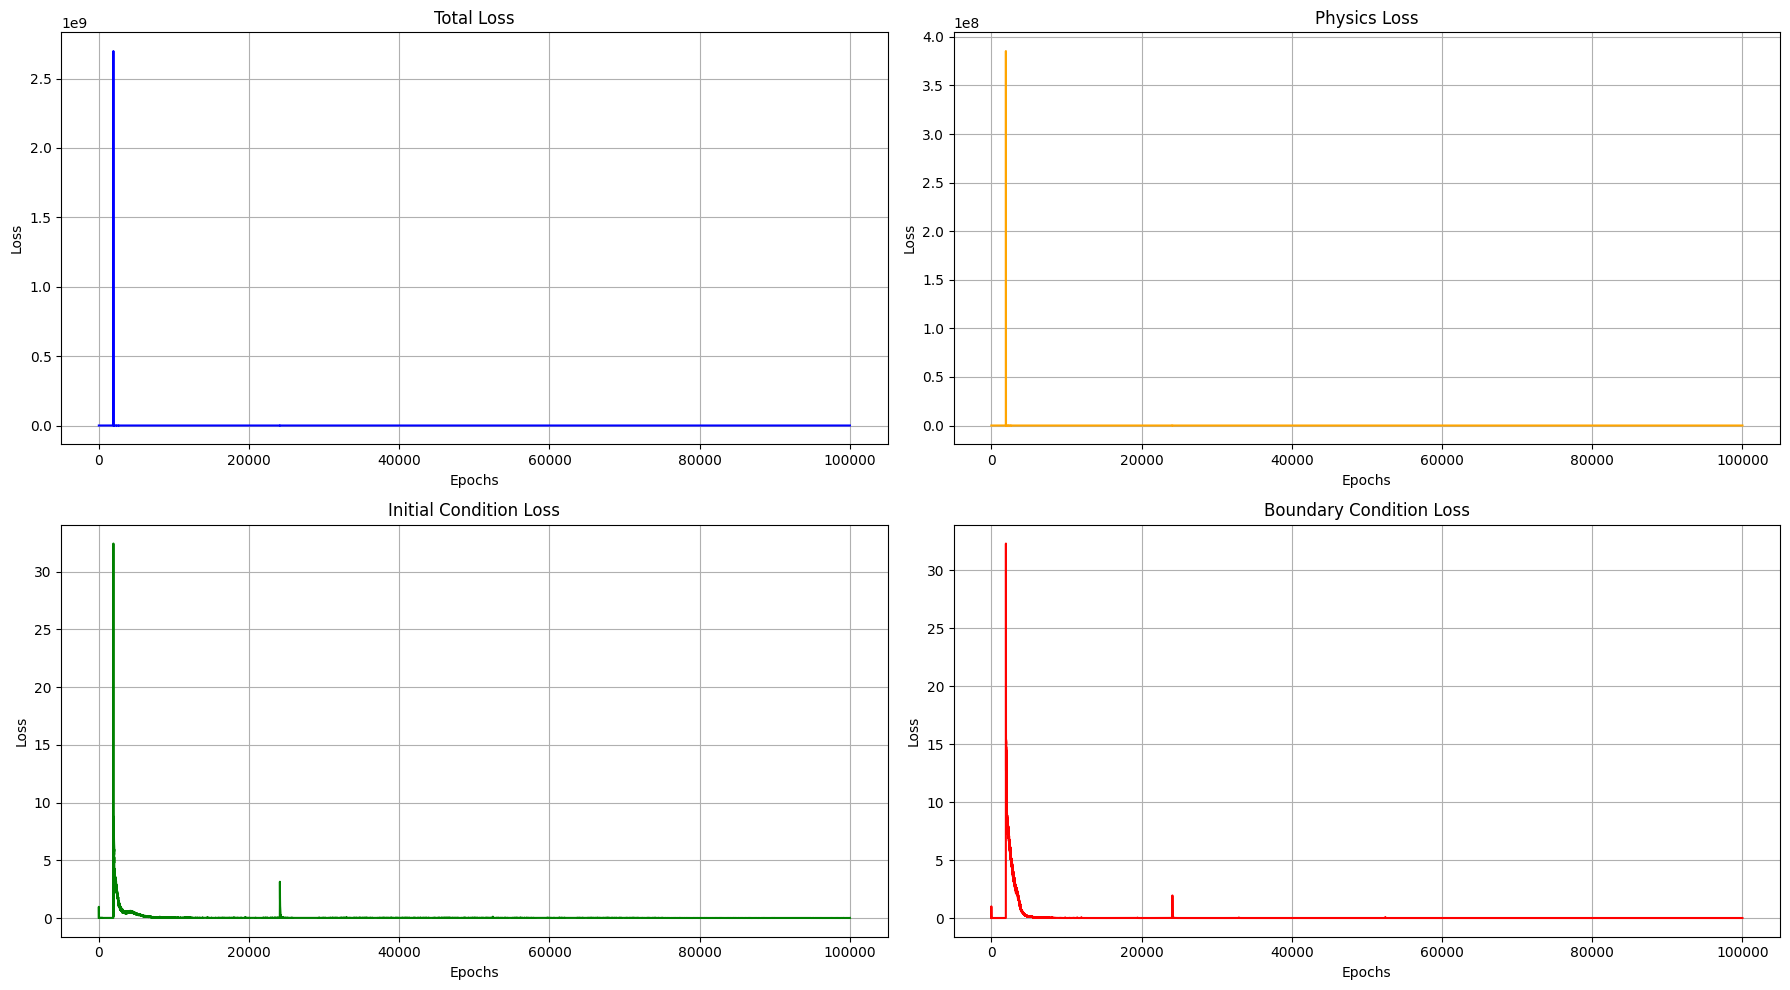

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

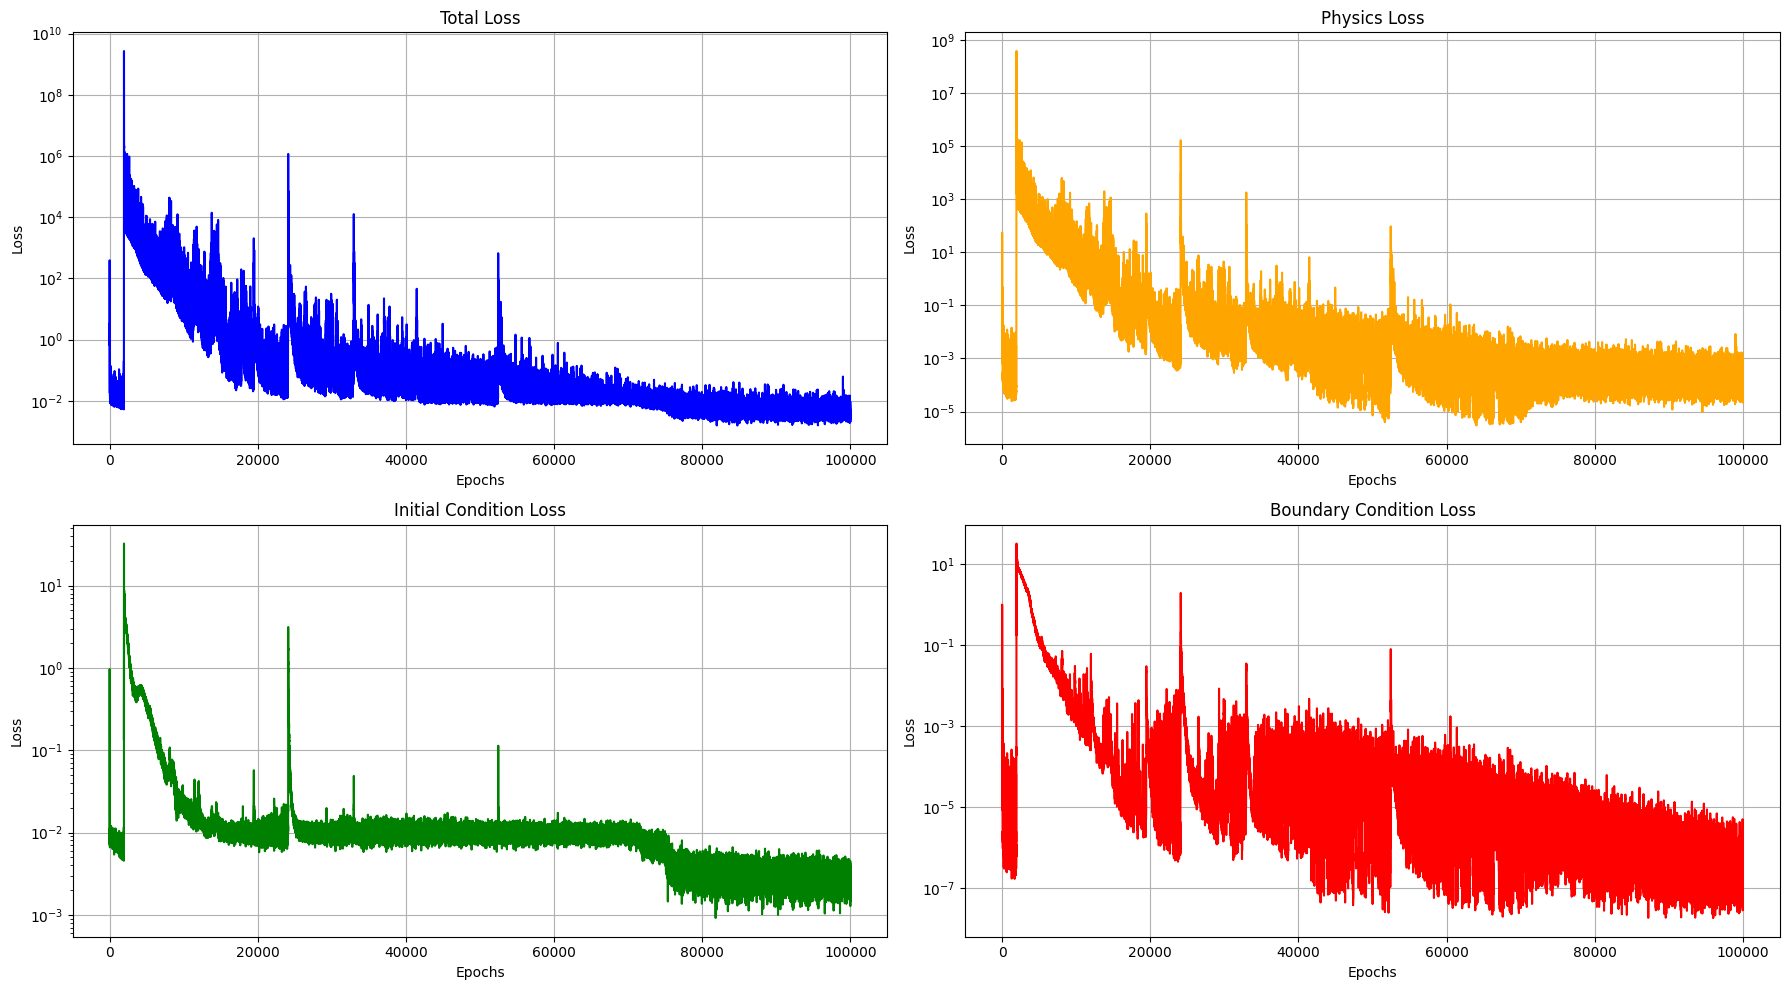

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_yscale("log")

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 1].set_yscale("log")

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[1, 0].set_yscale("log")

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)
axs[1, 1].set_yscale("log")

plt.tight_layout()
plt.show()

# Analytical

In [16]:
Nx = 600
Nt = 600

x_values = np.linspace(x_min, x_max, Nx)
t_values = np.linspace(t_min, t_max, Nt)

In [17]:
E0 = 0.5 * omega * hbar
A = (m * omega / (np.pi * hbar)) ** 0.25
alpha = (m * omega) / (2.0 * hbar)

# psi(x, t) = psi(x, 0) * exp(-i * (E0 / hbar) * t)
# psi(x, 0) = A * exp(-alpha * x ** 2)

In [18]:
psi_real_analytical = np.zeros((Nx, Nt), dtype=np.float64)
psi_img_analytical = np.zeros((Nx, Nt), dtype=np.float64)

for i, x in enumerate(x_values):
  psi0_x = A * np.exp(-alpha * x ** 2)

  for j, t in enumerate(t_values):
    phase = -E0 * t / hbar
    exp_phase = np.exp(1j * phase)

    psi_x_t = psi0_x * exp_phase

    psi_real_analytical[i, j] = np.real(psi_x_t)
    psi_img_analytical[i, j] = np.imag(psi_x_t)

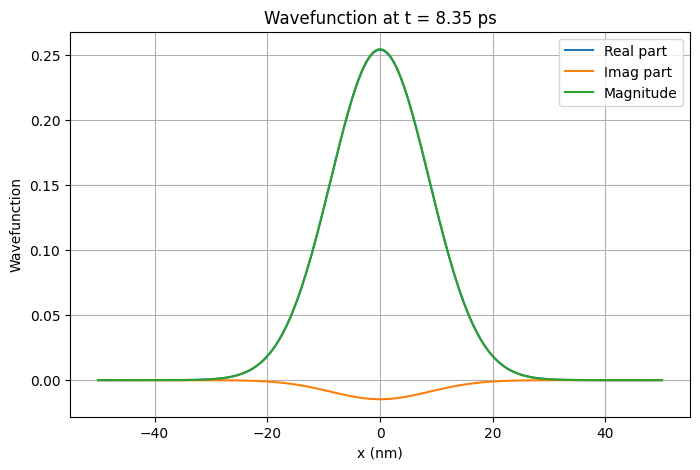

In [19]:
time_index = 100
time_chosen = t_values[time_index]

psi_real_slice_analytical = psi_real_analytical[:, time_index]
psi_img_slice_analytical = psi_img_analytical[:, time_index]

psi_mag_slice_analytical = np.sqrt(psi_real_slice_analytical**2 + psi_img_slice_analytical**2)

plt.figure(figsize=(8,5))
plt.plot(x_values, psi_real_slice_analytical, label='Real part')
plt.plot(x_values, psi_img_slice_analytical, label='Imag part')
plt.plot(x_values, psi_mag_slice_analytical, label='Magnitude')
plt.title(f'Wavefunction at t = {time_chosen:.2f} ps')
plt.xlabel('x (nm)')
plt.ylabel('Wavefunction')
plt.legend()
plt.grid(True)
plt.show()


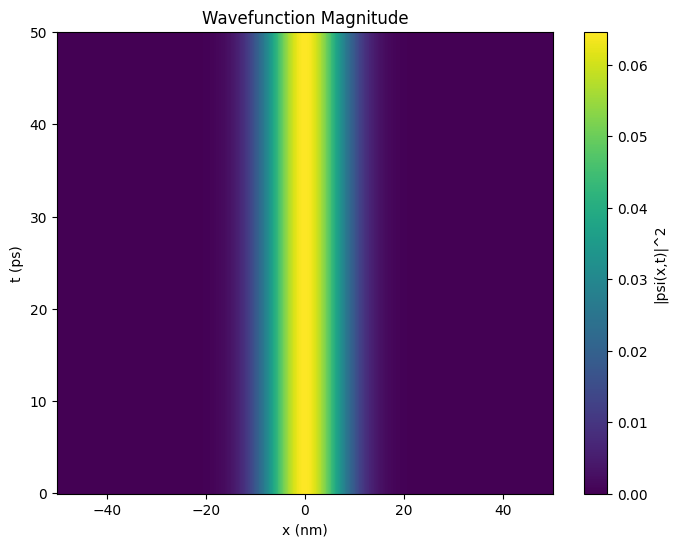

In [20]:
plt.figure(figsize=(8, 6))
psi_sq = psi_real_analytical ** 2 + psi_img_analytical ** 2

plt.pcolormesh(x_values, t_values, psi_sq.transpose(), shading="auto")
plt.colorbar(label='|psi(x,t)|^2')
plt.xlabel('x (nm)')
plt.ylabel('t (ps)')
plt.title('Wavefunction Magnitude')
plt.show()

# Testing

In [21]:
Nx = 600
Nt = 600

x_values = np.linspace(x_min, x_max, Nx)
t_values = np.linspace(t_min, t_max, Nt)

In [22]:
x_values_torch = torch.from_numpy(x_values).float().to(device)
t_values_torch = torch.from_numpy(t_values).float().to(device)

x_grid, t_grid = torch.meshgrid(x_values_torch, t_values_torch, indexing="ij")

x_flat = torch.reshape(x_grid, [-1])
t_flat = torch.reshape(t_grid, [-1])

psi_real_pinn, psi_img_pinn = model((x_flat, t_flat))

psi_real_pinn = torch.reshape(psi_real_pinn, (Nx, Nt))
psi_img_pinn = torch.reshape(psi_img_pinn, (Nx, Nt))

psi_real_pinn = psi_real_pinn.detach().cpu().numpy()
psi_img_pinn = psi_img_pinn.detach().cpu().numpy()

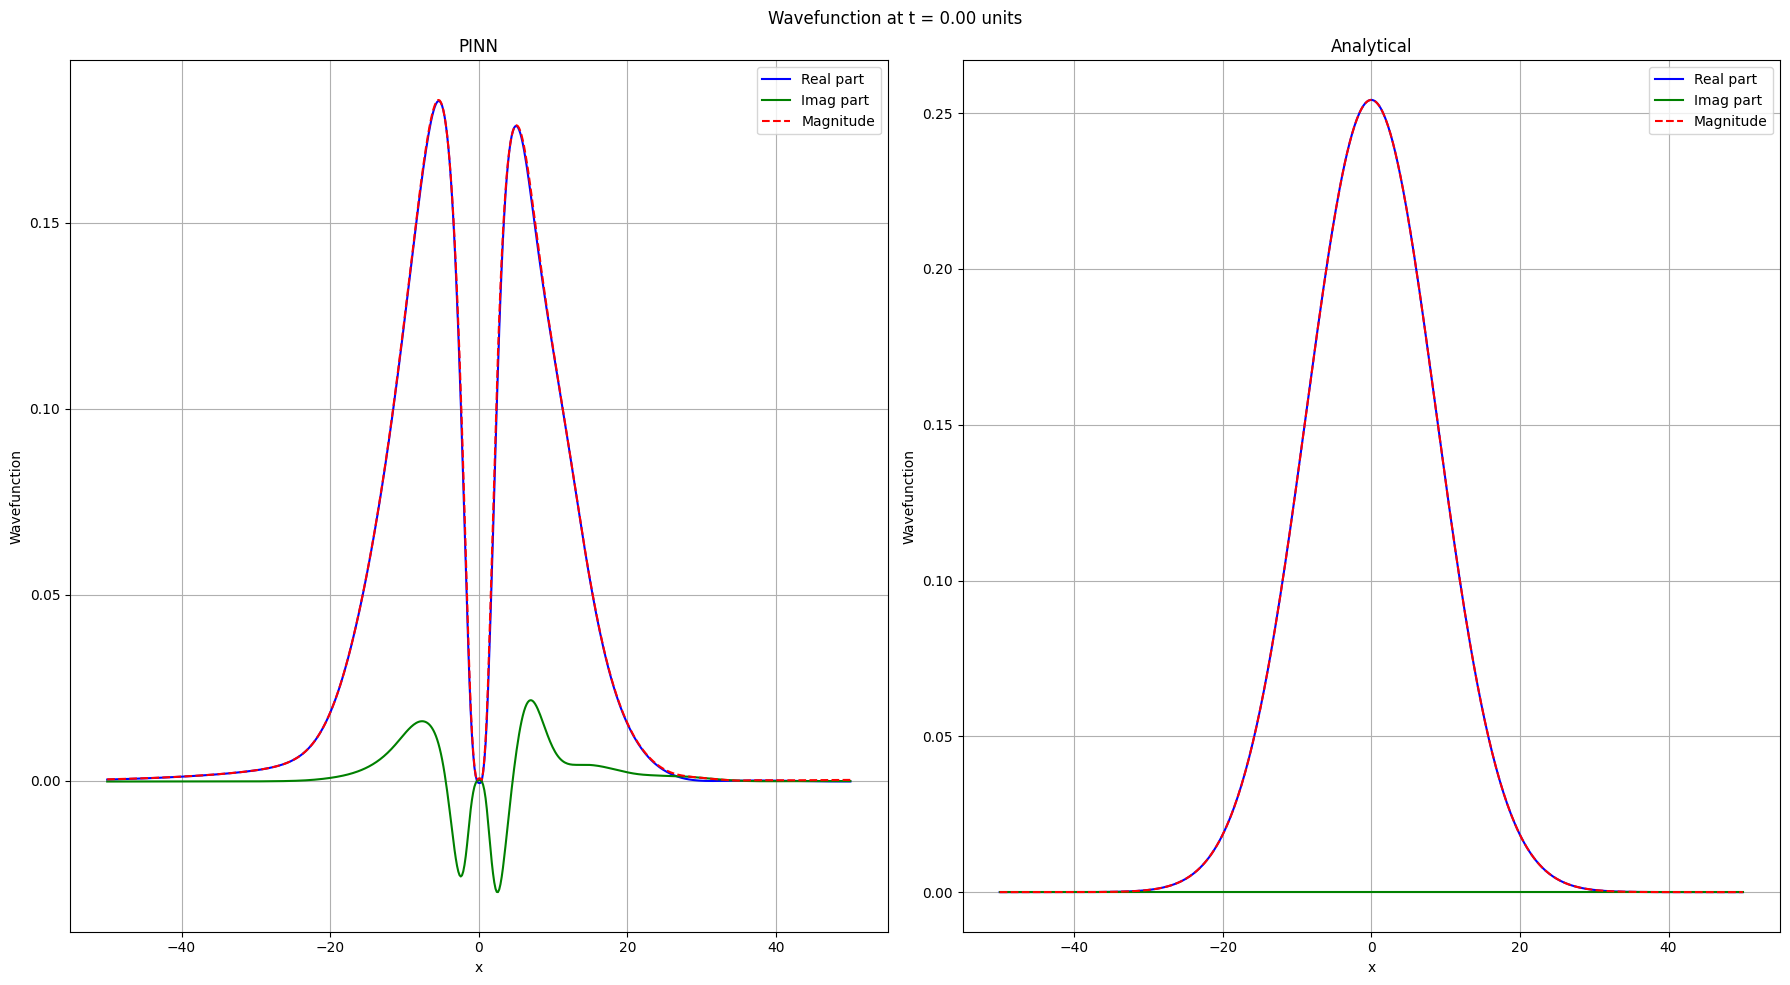

In [23]:
time_index = 0
time_chosen = t_values[time_index]

psi_real_slice_pinn = psi_real_pinn[:, time_index]
psi_imag_slice_pinn = psi_img_pinn[:, time_index]

psi_real_slice_analytical = psi_real_analytical[:, time_index]
psi_img_slice_analytical = psi_img_analytical[:, time_index]

psi_mag_slice_pinn = np.sqrt(psi_real_slice_pinn ** 2 + psi_imag_slice_pinn ** 2)
psi_mag_slice_analytical = np.sqrt(psi_real_slice_analytical ** 2 + psi_img_slice_analytical ** 2)

fig, axs = plt.subplots(1, 2, figsize=(18, 10))
plt.suptitle(f"Wavefunction at t = {time_chosen:.2f} units")

#pinn
axs[0].plot(x_values, psi_real_slice_pinn, label='Real part', color='blue')
axs[0].plot(x_values, psi_imag_slice_pinn, label='Imag part', color='green')
axs[0].plot(x_values, psi_mag_slice_pinn, '--', label='Magnitude', color='red')
axs[0].set_title(f'PINN')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Wavefunction')
axs[0].legend()
axs[0].grid(True)

#analytical
axs[1].plot(x_values, psi_real_slice_analytical, label='Real part', color='blue')
axs[1].plot(x_values, psi_img_slice_analytical, label='Imag part', color='green')
axs[1].plot(x_values, psi_mag_slice_analytical, '--', label='Magnitude', color='red')
axs[1].set_title(f'Analytical')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Wavefunction')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

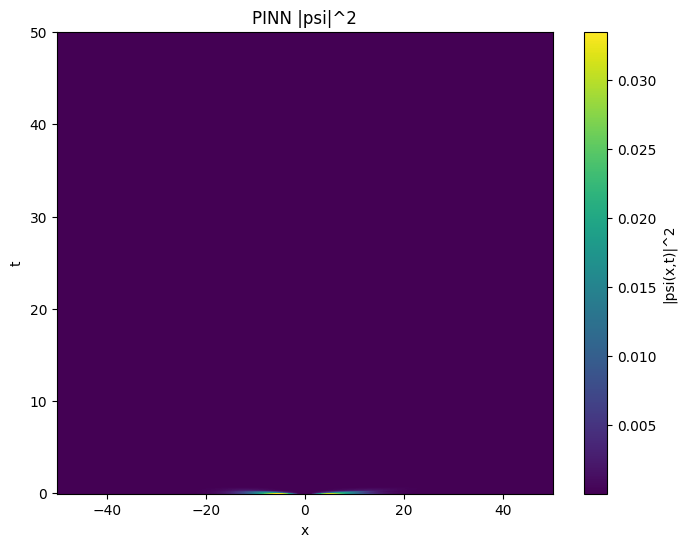

In [24]:
plt.figure(figsize=(8, 6))
psi_sq = psi_real_pinn ** 2 + psi_img_pinn ** 2

plt.pcolormesh(x_values, t_values, psi_sq.transpose(), shading="auto")
plt.colorbar(label='|psi(x,t)|^2')
plt.xlabel('x')
plt.ylabel('t')
plt.title('PINN |psi|^2')
plt.show()

In [25]:
psi_analytical_mag = psi_real_analytical ** 2 + psi_img_analytical ** 2
psi_pinn_mag = psi_real_pinn ** 2 + psi_img_pinn ** 2

mse = (np.square(psi_analytical_mag - psi_pinn_mag)).mean()

print(f"Mean Squared Error: {mse:.3e}")

Mean Squared Error: 4.555e-04
